# CNN Model

- input = image

- output = score (Mean Vol After Open / Mean Vol Before Open) 

### 0. Installation (torch & fastai)

In [2]:
# pip install torch===1.7.0 torchvision===0.8.1 torchaudio===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.
  Attempting uninstall: torch
    Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [4]:
# pip install fastai

  Using cached fastai-2.2.5-py3-none-any.whl (191 kB)
  Using cached spacy-2.3.5-cp37-cp37m-win_amd64.whl (9.5 MB)
  Using cached fastprogress-1.0.0-py3-none-any.whl (12 kB)
  Using cached fastcore-1.3.19-py3-none-any.whl (53 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
# pip install --upgrade pip

In [1]:
#pip show fastai

Name: fastai
Version: 2.2.5
Summary: fastai simplifies training fast and accurate neural nets using modern best practices
Home-page: https://github.com/fastai/fastai/tree/master/
Author: Jeremy Howard, Sylvain Gugger, and contributors
Author-email: info@fast.ai
License: Apache Software License 2.0
Location: /home/sehara/.local/lib/python3.7/site-packages
Requires: torchvision, scikit-learn, pyyaml, packaging, matplotlib, pandas, scipy, pillow, fastprogress, spacy, torch, requests, fastcore, pip
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [26]:
from fastai.vision.all import *
from fastai.metrics import error_rate

### 1. Data Prep

In [32]:
data = (ImageDataLoaders.from_csv('../data/imgs', 'image_label_dir.csv', valid_pct=0.2, seed=10, size=224))
#         .random_split_by_pct(valid_pct=0.2, seed=10))
#         .split_by_idxs(list(range(400)), list(range(400,496))))
#                  .label_from_df()
#                  .databunch())

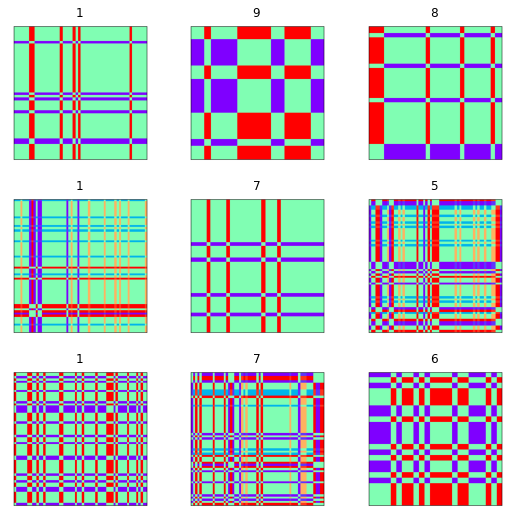

In [33]:
data.show_batch()

### 2. cnn model

In [34]:
learner = cnn_learner(data, models.resnet34, loss_func=mae, metrics=error_rate)
learner.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=10, bias=False)
)

### Tuning Model

In [35]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time


RuntimeError: DataLoader worker (pid 1316) is killed by signal: Killed. 

In [23]:
### Finding learning rate
learner.lr_find()
learner.recorder.plot(suggestion=True)

KeyboardInterrupt: 

In [ ]:
mingradlr = learner.recorder.min_grad_lr